In [2]:
from google.colab import drive #드라이브 연결
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch #라이브러리 import
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from math import log10
from torch.autograd import Variable
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
from torchsummary import summary

In [5]:
class CNN(nn.Module): # 모델 구조 (ResNet , GAN) 사용 예정
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False) # 3채널 -> 64 채널 , kernel_size 3 이지만 padding 1 로 이미지 크기 변화 없음                                                      
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, bias=False) # 64 채널 -> 32채널
        self.relu1 = nn.ReLU(inplace=True) #ReLu 활성화 함수
        self.drop1 = nn.Dropout(p=0.25)

        hidden_layers = []
        for i in range(32): #32 겹 hidden layers
          hidden_layers.append(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, bias=False)) 
          hidden_layers.append(nn.BatchNorm2d(32))
          hidden_layers.append(nn.ReLU(inplace=True))
        self.mid_layer = nn.Sequential(*hidden_layers)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1, bias=False)


    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.relu1(self.conv2(out))
        out = self.drop1(out)
        out = self.mid_layer(out)
        out = self.conv3(out)
        return out

In [6]:
summary(CNN().cuda(), (3, 128, 128)) #모델 요약

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]          18,432
              ReLU-4         [-1, 32, 128, 128]               0
           Dropout-5         [-1, 32, 128, 128]               0
            Conv2d-6         [-1, 32, 128, 128]           9,216
       BatchNorm2d-7         [-1, 32, 128, 128]              64
              ReLU-8         [-1, 32, 128, 128]               0
            Conv2d-9         [-1, 32, 128, 128]           9,216
      BatchNorm2d-10         [-1, 32, 128, 128]              64
             ReLU-11         [-1, 32, 128, 128]               0
           Conv2d-12         [-1, 32, 128, 128]           9,216
      BatchNorm2d-13         [-1, 32, 128, 128]              64
             ReLU-14         [-1, 32, 1

In [ ]:
def is_image_file(filename): # 이미지 파일 로드 함수 오픈소스 사용
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".gif"])

In [ ]:
class ImageDataset(Dataset): # 이미지 파일 로드 함수 오픈소스 사용

  def __init__(self, image_dir, input_transforms=None):
      super(ImageDataset, self).__init__()
      self.image_filenames = [os.path.join(image_dir, x) for x in os.listdir(image_dir) if is_image_file(x)]
      self.input_transforms = input_transforms

  def __getitem__(self, index):
      input = Image.open(self.image_filenames[index])

      if self.input_transforms:
        input = self.input_transforms(input)
      
      return input
  
  def __len__(self):
      return len(self.image_filenames)

In [ ]:
trans = transforms.Compose([
                            transforms.Resize((128,128)),
                            transforms.ToTensor(),
                            ]) # 이미지 128 x 128 사이즈 변경, tensor 로 변환


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # gpu 사용 가능하면 gpu 사용

train_dir = '/content/drive/MyDrive/tst/seg_train/seg_train/mountain' #trainset 경로
# test_dir =  '/content/drive/MyDrive/tst/seg_train/seg_train/forest' #testset 경로 아직 미사용

train_dataset = ImageDataset(train_dir, input_transforms=trans) # trainset 로드후 텐서 변환

print(len(train_dataset)) //trainset 개수 출력

training_data_loader = DataLoader(dataset=train_dataset, batch_size=64) # trainset batch_size 설정후 모델에 올릴수 있는 형태로 변환 DataLoader pytorch 자체 함수

model = CNN().to(device) #모델 정의
MSE = nn.MSELoss() #MSE 손실함수 사용
lr = 1e-2 #0.01
optimizer = optim.SGD(model.parameters(), lr=lr) # SGC Optimizer

2512


In [ ]:
def gaussian(ins, is_training, mean, stddev=0.1): #노이즈 생성 함수 오픈소스 사용
    noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
    return ins + noise, noise

In [ ]:
ts = transforms.ToPILImage() # tensor 배열을 이미지로 변환
def train(epoch): # epoch 만큼 학습 반복
    epoch_loss = 0
    for iteration, data in enumerate(training_data_loader, 1):

        target = data #target = 원본 사진
        input, noise = gaussian(target, 0, 0.05) #input = 노이즈 있는 사진, noise = input - target 노이즈만 있는 사진

        input = Variable(input.cuda())
        noise = Variable(noise.cuda())
        target = Variable(target.cuda())

        output = model(input)

        loss = MSE(output, noise) #output = noise 가 되도록 학습 : 노이즈 낀 사진을 모델에 넣으면 노이즈만 output 으로 나온다 후에 (노이즈 낀 사진 - 모델 output) 하면 노이즈가 제거된 사진이 나온다. 
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        print("Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

In [ ]:
def save_checkpoint(state): //epoch 마다 모델 저장
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(state, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

In [ ]:
num_epochs = 10000
for epoch in range(1, num_epochs + 1):
    train(epoch)
    if epoch % 1 == 0:
      save_checkpoint({
          'epoch': epoch + 1,
          'arch': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(),
      })

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch[90](10/40): Loss: 0.0102
Epoch[90](11/40): Loss: 0.0102
Epoch[90](12/40): Loss: 0.0102
Epoch[90](13/40): Loss: 0.0101
Epoch[90](14/40): Loss: 0.0102
Epoch[90](15/40): Loss: 0.0102
Epoch[90](16/40): Loss: 0.0102
Epoch[90](17/40): Loss: 0.0102
Epoch[90](18/40): Loss: 0.0101
Epoch[90](19/40): Loss: 0.0102
Epoch[90](20/40): Loss: 0.0102
Epoch[90](21/40): Loss: 0.0102
Epoch[90](22/40): Loss: 0.0102
Epoch[90](23/40): Loss: 0.0101
Epoch[90](24/40): Loss: 0.0102
Epoch[90](25/40): Loss: 0.0102
Epoch[90](26/40): Loss: 0.0102
Epoch[90](27/40): Loss: 0.0102
Epoch[90](28/40): Loss: 0.0101
Epoch[90](29/40): Loss: 0.0101
Epoch[90](30/40): Loss: 0.0102
Epoch[90](31/40): Loss: 0.0102
Epoch[90](32/40): Loss: 0.0101
Epoch[90](33/40): Loss: 0.0102
Epoch[90](34/40): Loss: 0.0101
Epoch[90](35/40): Loss: 0.0101
Epoch[90](36/40): Loss: 0.0102
Epoch[90](37/40): Loss: 0.0102
Epoch[90](38/40): Loss: 0.0102
Epoch[90](39/40): Loss: 0.0102
Epoch[90](40/40): Loss: 0.0102
Epo

KeyboardInterrupt: ignored

In [ ]:
model = torch.load('/content/model_epoch_200.pth') // 모델 경로 불러오기



model = model['arch'] //모델 구조 추출

loader = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor()
    ])


def image_loader(image_name): // 이미지 로더
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0) 

    return image.cuda()


def remove_noise(model, image): // 노이즈 이미지 - model output 이미지 계산 함수
    out = torch.clamp(image-model(image), 0., 1.)
    out = out.cpu().clone()
    out = out.squeeze(0)
    trans = transforms.ToPILImage()
    plt.imshow(trans(out))
    trans(out).save('out.png')

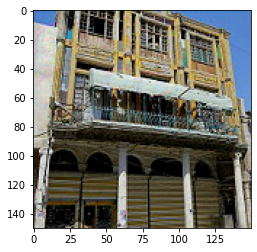

In [ ]:
img_path = '/content/drive/MyDrive/tm/24258.jpg'

image = image_loader(img_path)

input, noise = gaussian(image, 0, 0.05)

remove_noise(model, image)

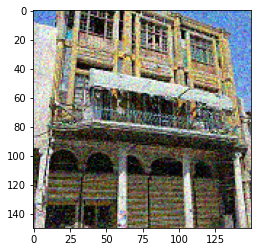

In [ ]:
img_path = '/content/drive/MyDrive/tm/24258.jpg'

image = image_loader(img_path)

input, noise = gaussian(image, 0, 0.05)

remove_noise(model, input)

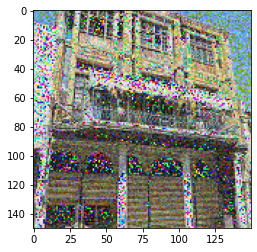

In [ ]:
img_path = '/content/drive/MyDrive/tm/24258.jpg'

image = image_loader(img_path)

input, noise = gaussian(image, 0, 0.05)

plt.imshow(ts(input[0]))
